In [6]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

                                  Grouped by params.learning                                  
                                         Attention Induction             Base   Rank Induction
n                                                         10               10               10
metrics.test_auroc, mean (SD)                0.7429 (0.1426)  0.7408 (0.1464)  0.8395 (0.0444)
metrics.test_prauc, mean (SD)                0.7277 (0.1792)  0.7303 (0.1831)  0.8509 (0.0368)
metrics.test_accuracy, mean (SD)             0.7705 (0.0863)  0.7783 (0.0928)  0.8419 (0.0194)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

AUPRC_Attention Induction v.s. AUPRC_Rank Induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.287e-02 U_stat=2.000e+01
Accuracy_Attention Induction v.s. Accuracy_Rank Induction: Mann-Whitney-Wilcoxon test smaller, P_val=1.694e-03 U_stat=1.100e+01


/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


AUROC_Attention Induction v.s. AUROC_Rank Induction: Mann-Whitney-Wilcoxon test smaller, P_val=3.201e-02 U_stat=2.500e+01
Accuracy_Base v.s. Accuracy_Rank Induction: Mann-Whitney-Wilcoxon test smaller, P_val=3.706e-02 U_stat=2.600e+01
AUPRC_Base v.s. AUPRC_Rank Induction: Mann-Whitney-Wilcoxon test smaller, P_val=2.695e-02 U_stat=2.400e+01
AUROC_Base v.s. AUROC_Rank Induction: Mann-Whitney-Wilcoxon test smaller, P_val=3.201e-02 U_stat=2.500e+01


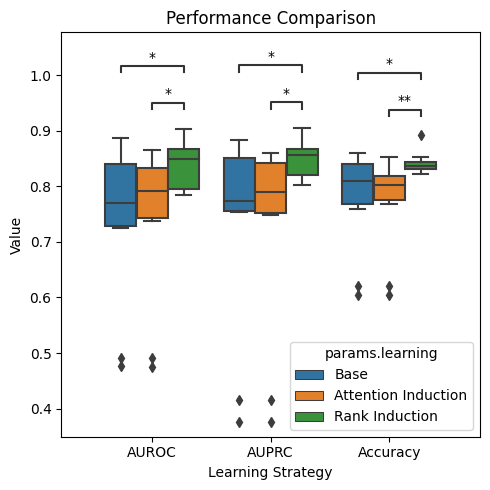

In [7]:
import seaborn as sns
import pandas as pd

from tableone import TableOne
from scipy import stats
from matplotlib import pyplot as plt
from statannot import add_stat_annotation

base_rows = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=(
        "params.learning = 'base' "
        "AND params.sampling_ratio = '1.0' "
        # "AND params.morphology_value = 'None'"
    )
)
att_rows = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=(
        "params.learning = 'attention_induction' "
        "AND params.sampling_ratio = '1.0' "
        "AND params._lambda = '1.0' "
        "AND params.threshold = 'None' "
        # "AND params.morphology_value = 'None'"
    )
)
ltr_rows = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=(
        "params.learning = 'ltr' "
        "AND params.sampling_ratio = '1.0' "
        "AND params._lambda = '1.0' "
        "AND params.threshold = '1.0' "
        # "AND params.morphology_value = 'None' "
    )
)
data = pd.concat([base_rows, att_rows, ltr_rows])
data = data.loc[
    (data["params.morphology_value"].isna() & data["params.dataset"].isna())
].reset_index(drop=True)

learning_strategy_map = {
    "base": "Base", 
    "attention_induction": "Attention Induction", 
    "ltr": "Rank Induction"
}
data['params.learning'] = data['params.learning'].map(learning_strategy_map)

data_view = data[["metrics.test_auroc", "metrics.test_prauc", "params.learning" ,"metrics.test_accuracy"]]
df_melted = data_view.melt(id_vars=["params.learning"], var_name="metric", value_name="value")
df_melted["metric"] = df_melted["metric"].str.replace("metrics.", "", regex=False)
df_melted["metric"] = df_melted["metric"].replace({
    "test_auroc": "AUROC", 
    "test_prauc": "AUPRC", 
    "test_accuracy": "Accuracy"
})

print(TableOne(data, 
    groupby="params.learning", 
    columns=["metrics.test_auroc", "metrics.test_prauc", "metrics.test_accuracy"], 
    decimals=4, 
    missing=False, 
    overall=False
))


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(data=df_melted, x="metric", y="value", hue="params.learning", ax=ax)

ax.set_xlabel("Learning Strategy")
ax.set_ylabel("Value")

# 필요하다면 타이틀 추가 가능
plt.title("Performance Comparison")


box_pairs = [
    # AUROC
    (("AUROC", "Base"), ("AUROC", "Rank Induction")),
    (("AUROC", "Attention Induction"), ("AUROC", "Rank Induction")),
    
    # AUPRC
    (("AUPRC", "Base"), ("AUPRC", "Rank Induction")),
    (("AUPRC", "Attention Induction"), ("AUPRC", "Rank Induction")),
    
    # Accuracy
    (("Accuracy", "Base"), ("Accuracy", "Rank Induction")),
    (("Accuracy", "Attention Induction"), ("Accuracy", "Rank Induction")),
]


add_stat_annotation(ax, 
    data=df_melted, 
    x="metric", 
    y="value", 
    hue="params.learning", 
    box_pairs=box_pairs, 
    test="Mann-Whitney-ls",
    text_format="star",
    loc="inside", 
    verbose=2,
    comparisons_correction=None  # 다중 비교 보정 제거
)

plt.tight_layout()
plt.show()

/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


AUPRC_Attention Induction w/ threshold v.s. AUPRC_Rank Induction: Mann-Whitney-Wilcoxon test two-sided, P_val=3.148e-01 U_stat=2.400e+01
Accuracy_Base v.s. Accuracy_Attention Induction w/ threshold: Mann-Whitney-Wilcoxon test two-sided, P_val=4.051e-01 U_stat=2.600e+01
Accuracy_Attention Induction w/ threshold v.s. Accuracy_Rank Induction: Mann-Whitney-Wilcoxon test two-sided, P_val=2.986e-01 U_stat=2.400e+01
AUROC_Base v.s. AUROC_Attention Induction w/ threshold: Mann-Whitney-Wilcoxon test two-sided, P_val=3.638e-01 U_stat=2.500e+01
AUROC_Attention Induction w/ threshold v.s. AUROC_Rank Induction: Mann-Whitney-Wilcoxon test two-sided, P_val=6.691e-01 U_stat=3.000e+01
AUPRC_Base v.s. AUPRC_Attention Induction w/ threshold: Mann-Whitney-Wilcoxon test two-sided, P_val=4.173e-01 U_stat=2.600e+01
Accuracy_Base v.s. Accuracy_Rank Induction: Mann-Whitney-Wilcoxon test two-sided, P_val=7.412e-02 U_stat=2.600e+01
AUPRC_Base v.s. AUPRC_Rank Induction: Mann-Whitney-Wilcoxon test two-sided, P_val

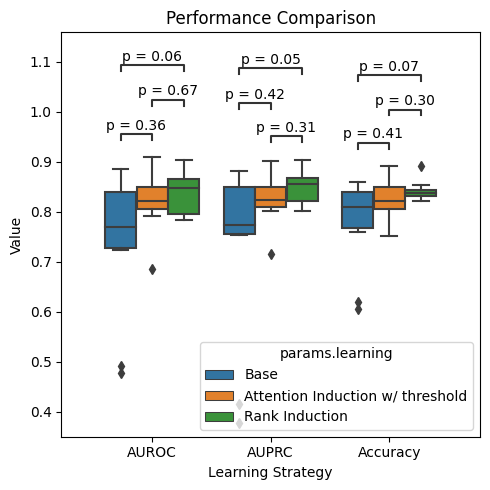

In [8]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from statannot import add_stat_annotation

base_rows = mlflow.search_runs(experiment_names=["attention_induction"], filter_string="params.learning = 'base' AND params.sampling_ratio = '1.0'")
att_rows = mlflow.search_runs(experiment_names=["attention_induction"], filter_string="params.learning = 'attention_induction' AND params.sampling_ratio = '1.0' AND params._lambda = '1.0' AND params.threshold = '1.0'")
ltr_rows = mlflow.search_runs(experiment_names=["attention_induction"], filter_string="params.learning = 'ltr' AND params.sampling_ratio = '1.0' AND params._lambda = '1.0' AND params.threshold = '1.0'")
data = pd.concat([base_rows, att_rows, ltr_rows])
data = data.loc[data["params.morphology_value"].isna()]

learning_strategy_map = {
    "base": "Base", 
    "attention_induction": "Attention Induction w/ threshold", 
    "ltr": "Rank Induction"
}
data['params.learning'] = data['params.learning'].map(learning_strategy_map)

data_view = data[["metrics.test_auroc", "metrics.test_prauc", "params.learning" ,"metrics.test_accuracy"]]
df_melted = data_view.melt(id_vars=["params.learning"], var_name="metric", value_name="value")
df_melted["metric"] = df_melted["metric"].str.replace("metrics.", "", regex=False)
df_melted["metric"] = df_melted["metric"].replace({
    "test_auroc": "AUROC", 
    "test_prauc": "AUPRC", 
    "test_accuracy": "Accuracy"
})

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(data=df_melted, x="metric", y="value", hue="params.learning", ax=ax)

ax.set_xlabel("Learning Strategy")
ax.set_ylabel("Value")

# 필요하다면 타이틀 추가 가능
plt.title("Performance Comparison")


box_pairs = [
    (("AUROC", "Attention Induction w/ threshold"), ("AUROC", "Base")),
    (("AUROC", "Attention Induction w/ threshold"), ("AUROC", "Rank Induction")),
    (("AUROC", "Base"), ("AUROC", "Rank Induction")),
    (("AUPRC", "Attention Induction w/ threshold"), ("AUPRC", "Base")),
    (("AUPRC", "Attention Induction w/ threshold"), ("AUPRC", "Rank Induction")),
    (("AUPRC", "Base"), ("AUPRC", "Rank Induction")),
    (("Accuracy", "Attention Induction w/ threshold"), ("Accuracy", "Base")),
    (("Accuracy", "Attention Induction w/ threshold"), ("Accuracy", "Rank Induction")),
    (("Accuracy", "Base"), ("Accuracy", "Rank Induction"))
]

add_stat_annotation(ax, 
    data=df_melted, 
    x="metric", 
    y="value", 
    hue="params.learning", 
    box_pairs=box_pairs, 
    test="Mann-Whitney", 
    text_format="simple", 
    loc="inside", 
    verbose=2,
    comparisons_correction=None  # 다중 비교 보정 제거
)

plt.tight_layout()
plt.show()